In [1]:
import numpy as np
import matplotlib.pyplot as plt

Consider a probabilistic classifier model. We have a labeled input, say $x$, which has the true label $c_{\text{true}} = 3$. We can represent this as a vector, $y_{\text{true}}$, where all entries are zero but the third, which is 1 (a "degenerate" discrete probability distribution). Assume our model outputs the distribution over classes, $y_{\text{pred}}$, given below: 

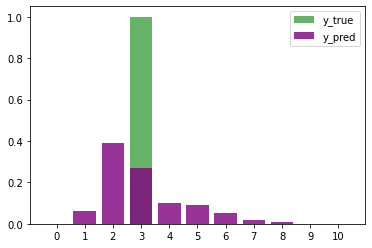

In [2]:
y_pred = np.array([0., 0.06, 0.39, 0.27, 0.1,  0.09, 0.05, 0.02, 0.01, 0., 0., ])
y_true = np.zeros_like(y_pred)
y_true[3] = 1.0

n_classes = len(y_pred)

fig, ax = plt.subplots()

ax.bar(range(n_classes), y_true, color='green', label='y_true', alpha=0.6)
ax.bar(range(n_classes), y_pred, color='purple', label='y_pred', alpha=0.8)
ax.legend(loc='upper right')
ax.set_xticks(range(n_classes))
ax.set_xticklabels([str(class_) for class_ in range(n_classes)])
plt.show()

This is an example where the true label of the input is $$c_{\text{true}} = 3,$$ but the maximum of the model's predicted class-conditional distribution is $$\argmax y_{\text{pred}} = 2.$$

Thus, naively taking $$ c_{\text{choice}} = \argmax y_{\text{pred}},$$ which is what the default confusion matrix does, will result in an incorrect classification for this example.

One reason is because our predictions don't match reality very well: the predicted distribution isn't particularly close to the actual distribution. We can theoretically improve the model (or use a different model) to get the predicted distribution closer to the actual distribution. This should always make our decision-making easier.

Another reason for our misclassification is that we're making a classification decision with accounting for any sort of "loss" associated with making the wrong decision. This makes sense in a way because there's inherently no real reason the decision process --- taking the argmax --- should assume any ordering among the discrete classes.

#### A Decision Loss Function

Assume for a moment that we know ahead of time the true class of the input, $c_{\text{true}}$. Let $c_{\text{choice}}$ represent the class label which we end up choosing to assign to that input; this is the *decision* we make. We will consider different possibilities for $c_{\text{choice}}$ and try to find the "best" one.

For this problem, we assume there is an inherent ordering to the class labels: the class labels represent days-to-deliver for an online order. If we predict, say, 2 days-to-deliver and the order actually takes 6, that would be bad; hence in this case **underpredicting is worse than overpredicting**. That is, we want to more heavily penalize choosing $c_{\text{choice}}$ if $c_{\text{choice}} < c_{\text{true}}$ than if not. The following simple loss function accomplishes this:

$$ \hat{L}\left(c_{\text{true}}, c_{\text{choice}}\right) = \left\{ \begin{array}{rl} 2, & \text{if } c_{\text{choice}} < c_{\text{true}} \\ 0, & \text{if } c_{\text{choice}} = c_{\text{true}} \\ 1, & \text{if } c_{\text{choice}} > c_{\text{true}} \end{array}\right. $$

However, notice for example that if $c_{\text{true}} = 3$, then choosing $c_{\text{choice}} = 3$ or $c_{\text{choice}} = 9$ will give us the same loss!

We can refine this loss function slightly to penalize the distance of $c_{\text{choice}}$ from $c_{\text{true}}$:

$$ L\left(c_{\text{true}}, c_{\text{pred}}\right) = \left\{ \begin{array}{rl} 2\left(c_{\text{true}} - c_{\text{pred}}\right), & \text{if } c_{\text{pred}} < c_{\text{true}} \\ 1\left(c_{\text{pred}} - c_{\text{true}}\right), & \text{if } c_{\text{pred}} >= c_{\text{true}} \end{array}\right. $$

In [3]:
# this function returns the above loss function but allows us to pass arbitrary weights to it
# we'll use this later
def loss_factory(w_under, w_over):
    """
        w_under: penalty for under-predicting
        w_over: penalty for over-predicting
    """
    def loss(c_true, c_choice):
        """
            c_true: true label
            c_choice: chosen label
        """
        delta_ = np.abs(c_true - c_choice)
        w =  w_under if c_choice < c_true else w_over
        return w * delta_

    return loss

loss = loss_factory(w_under=2, w_over=1)

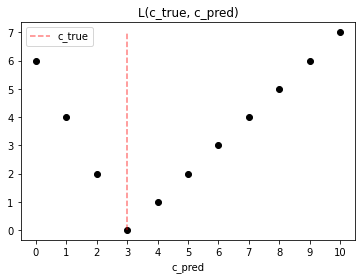

In [4]:
fig, ax = plt.subplots()

xp = np.arange(start=0, stop=n_classes)
c_true = 3

loss_ = [loss(c_true, x) for x in xp]
ax.vlines(c_true, 0, max(loss_), color='red', ls='--', alpha=0.5, label='c_true')
ax.scatter(xp, loss_, color='k')
ax.set_xticks(xp)
ax.set(xlabel='c_pred', title='L(c_true, c_pred)')
ax.legend()
plt.show()

We can see that this loss function greatly penalizes underpredicting the true class; it also penalizes overpredicting, but less so than underpredicting. In both cases, the penalty increases with "distance" from the true class.

Clearly, the choice of $c_{\text{choice}}$ which makes this loss minimal is the decision we should take.

The issue is that the value of $c_{\text{true}}$ is not actually known!

All we actually have to work with is $y_{\text{pred}}$, which is a *distribution over possible values of the true label*.

What this means is that when we make a decision by choosing $c_{\text{choice}}$, we can't compute the actual loss of this choice. Instead, we can compute the **expected loss** for this choice, which is a probability-weighted average loss for making this choice in light of what we (our model) currently believe to be the possible values for $c_{\text{true}}$.

$$ \mathbb{E}\left[ L\left(c'_{\text{true}}, c_{\text{choice}}\right) \right] = \sum_{c'} p\left(c'\right) \cdot L\left(c', c_{\text{choice}}\right) $$
where $p\left(\cdot\right) = y_{\text{pred}}$ is the distribution predicted by our model.

In [5]:
def calc_expected_losses(y_pred, classes, loss):
    return [
        sum([y_pred[c] * loss(c, c_choice) for c in classes])
        for c_choice in classes
    ]

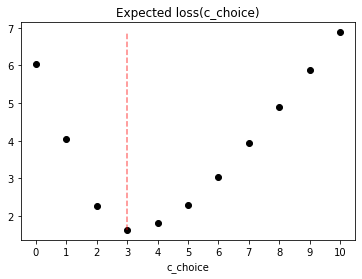

In [6]:
fig, ax = plt.subplots()

classes = np.arange(start=0, stop=n_classes)

expected_losses = calc_expected_losses(y_pred, classes, loss)

ax.vlines(c_true, min(expected_losses), max(expected_losses), color='red', ls='--', alpha=0.5, label='c_true')
ax.scatter(classes, expected_losses, color='k')
ax.set_xticks(classes)
ax.set(xlabel='c_choice', title='Expected loss(c_choice)')
plt.show()

We can see that the minimum of this loss function is at 3, which is exactly the true label!

After setting up some simple plotting utility code, we will look at some more examples and tweaks.

In [7]:
def plot_decision_losses(y_pred, loss, c_true = None, ax = None):
    """
        y_pred: distribution over classes (output from model)
        loss: loss function to use
        c_true: true class label, for comparison purposes 
        ax: optional axis array object
    """
    if ax is None:
        fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

    classes = np.arange(start=0, stop=n_classes)
    expected_losses = calc_expected_losses(y_pred, classes, loss)

    ax[0].bar(classes, y_pred, color='purple', label='y_pred', alpha=0.8)
    ax[0].set_xticks(classes)

    ax[1].scatter(classes, expected_losses, color='k')
    ax[1].set_xticks(classes)
    ax[1].set(xlabel='c_choice', title='Expected loss(c_choice)')
    
    if c_true:
        y_true = np.zeros_like(y_pred)
        y_true[c_true] = 1.0
        ax[0].bar(classes, y_true, color='green', label='y_true', alpha=0.6)
        ax[1].vlines(c_true, min(expected_losses), max(expected_losses), color='red', ls='--', alpha=0.5, label='c_true')
    
    ax[0].legend(loc='upper right')

    plt.show()

Let's try again on a different example. This one is "easier" in the sense that $c_{\text{true}} = 3$ and $y_{\text{pred}}$ still has it's argmax at 2, but the second highest value is a lot closer to it's max. Thus, the loss function shouldn't need to penalize as hard to get this right.

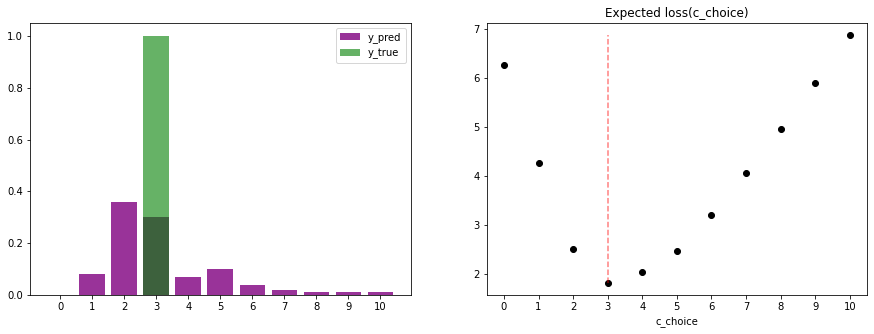

In [8]:
y_pred2 = [0., 0.08, 0.36, 0.30, 0.07, 0.1, 0.04, 0.02, 0.01, 0.01, 0.01]
c_true = 3

plot_decision_losses(y_pred2, loss, c_true)

Again we get it right where the naive argmax decision would not.

The following example is extreme but shows how we will still make the wrong decision if the predicted probabilities, $y_{\text{pred}}$, don't quite match reality. In this example, the probability mass is weighted too heavily toward classes 2 and 1, and even our loss-informed decision doesn't save us from making the wrong choice.

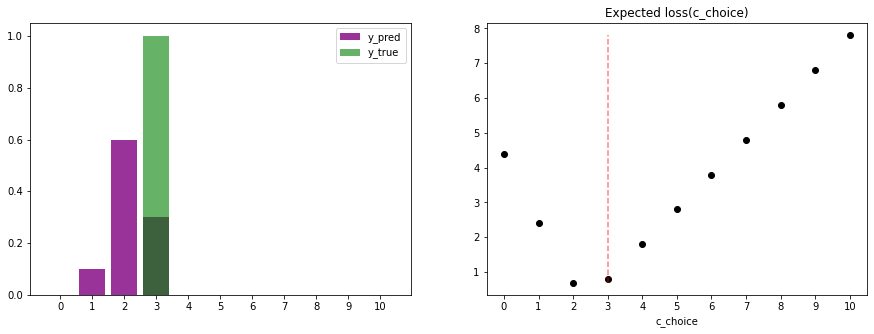

In [9]:
y_pred2 = [0., 0.1, 0.60, 0.30, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
c_true = 3

plot_decision_losses(y_pred2, loss, c_true)

However, by tweaking the parameters of the loss function, we can change how heavily the loss function penalizes the mistakes. 

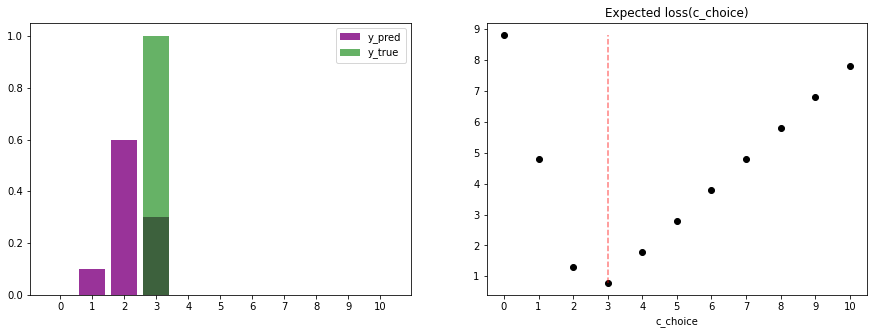

In [10]:
y_pred2 = [0., 0.1, 0.60, 0.30, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
c_true = 3

loss2 = loss_factory(w_under=4, w_over=1)

plot_decision_losses(y_pred2, loss2, c_true)

Thus, our loss function has two weight parameters. To simplify this, note:


$$\begin{align*} L\left(c_{\text{true}}, c_{\text{pred}}\right) & = \left\{ \begin{array}{rl} w_{\text{under}}\left(c_{\text{true}} - c_{\text{pred}}\right), & \text{if } c_{\text{pred}} < c_{\text{true}} \\ w_{\text{over}}\left(c_{\text{pred}} - c_{\text{true}}\right), & \text{if } c_{\text{pred}} >= c_{\text{true}} \end{array}\right. \\ & = w_{\text{over}} \left\{ \begin{array}{rl} \frac{w_{\text{under}}}{w_{\text{over}}}\left(c_{\text{true}} - c_{\text{pred}}\right), & \text{if } c_{\text{pred}} < c_{\text{true}} \\ \left(c_{\text{pred}} - c_{\text{true}}\right), & \text{if } c_{\text{pred}} >= c_{\text{true}} \end{array}\right. \\ \end{align*} $$

Since the only thing that matters is the relative loss between each choice $c_{\text{pred}}$, all that matters is the relative scale of the losses. Thus we can treat this as a single parameter, governing the relative weight of the underpredictions to the overpredictions. 

Thus, we can redefine the loss function as

\begin{equation} 
L_{\alpha}\left(c_{\text{true}}, c_{\text{pred}}\right) = \left\{ \begin{array}{rl} \alpha \left(c_{\text{true}} - c_{\text{pred}}\right), & \text{if } c_{\text{pred}} < c_{\text{true}} \\ \left(c_{\text{pred}} - c_{\text{true}}\right), & \text{if } c_{\text{pred}} >= c_{\text{true}} \end{array}\right. 
\end{equation}

where larger values of $\alpha >= 1$ penalize underprediction for heavily.

In [11]:
def loss_factory(alpha):
    """
        alpha: relative penalty for under-predicting (>=1)
    """
    def loss(c_true, c_choice):
        """
            c_true: true label
            c_choice: chosen label
        """
        delta_ = np.abs(c_true - c_choice)
        w =  alpha if c_choice < c_true else 1
        return w * delta_

    return loss

Try this out for different values of alpha!

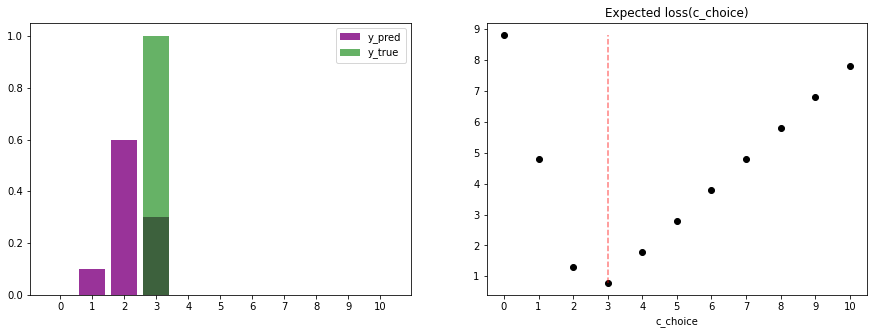

In [12]:
alpha = 4  # change this

y_pred = [0., 0.1, 0.60, 0.30, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
c_true = 3

plot_decision_losses(
    y_pred,
    loss_factory(alpha),
    c_true,
    )